In [1]:
#!/usr/bin/env/python
"""
Pyrate - Optical raytracing based on Python

Copyright (C) 2014-2018
               by     Moritz Esslinger moritz.esslinger@web.de
               and    Johannes Hartung j.hartung@gmx.net
               and    Uwe Lippmann  uwe.lippmann@web.de
               and    Thomas Heinze t.heinze@uni-jena.de
               and    others

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
"""

#import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'

from pyrateoptics import build_rotationally_symmetric_optical_system, draw
from pyrateoptics.sampling2d import raster
from pyrateoptics.raytracer.globalconstants import standard_wavelength, degree
from pyrateoptics.raytracer.aim import Aimy
from pyrateoptics.raytracer.ray import RayBundle

np.random.seed(1337)

#logging.basicConfig(level=logging.INFO)

def correct_k_E_initialbundle(initialraybundle):
    """
    Projection to obtain E, k which both satisfy the dispersion relation.
    The initial E field of Aimy introduces an anisotropy which violates the dispersion relation
    in such a manner that the ray direction is also incorrect.

    This is a quick and dirty solution.
    """
    ik = initialraybundle.k[0, :, :]
    ie = initialraybundle.Efield[0, :, :]
    ieprime = ie - ik*np.sum(ik*ie, axis=0)/np.sum(ik*ik, axis=0)
    initialraybundle.Efield[0, :, :] = ieprime
    return initialraybundle

First, let's build the Optical System. This system is the same as shown in https://github.com/mess42/pyrate/blob/07c5c0dca0bff50172aaca930a607b2836050e8f/demos/demo_benchmark.py but surface 6 has been moved back 1mm in order to make the image more blurred.

In summary:

The first lens is placed 2mm from the object and is 3mm thick with R1=-5.992mm, R2 = -3.160mm, and n=1.7; the second lens is placed 10mm from the object and is 3mm thick with R1= 15.884mm,  R2 = -12.756mm, and n=1.7; and the third lens is placed 18mm from the object and is 4mm thick with R1= 3.125mm, R2 = 1.479mm, and n=1.5. A stop aperture is also used at 16mm from the object and the image is formed 41mm from the object.

In [2]:
# Definition of optical system

db_path = "refractiveindex.info-database/database"

(s, seq) = build_rotationally_symmetric_optical_system(
        [(-5.922, 0, 2.0, 1.7, "surf1", {}),
         (-3.160, 0, 3.0, None, "surf2", {}),
         (15.884, 0, 5.0, 1.7, "surf3", {}),
         (-12.756, 0, 3.0, None, "surf4", {}),
         (0, 0, 3.0, None, "stop", {"is_stop": True}),
         (3.125, 0, 2.0, 1.5, "surf5", {}),
         (1.479, 0, 4.0, None, "surf6", {}),
         (0, 0, 19.0, None, "surf7", {})
         ], material_db_path=db_path)

Material key 1.7 already taken. Material will not be added.


Now lets create some rays to draw along with our optical system

In [3]:
# End point locations for both x and y of the object grid
start_loc = -0.5
end_loc = 0.5

# Numer of field points to draw
num_fp_draw = 5
# Number of rays per point to trace when showing the optical system
num_rays_draw = 5
# y locations for the object rays to draw
y_grid = np.linspace(start_loc, end_loc, num_fp_draw)

# Create field points
a_draw = Aimy(s, seq, name="Aimy_drawing", stopsize=1.0, num_pupil_points=num_rays_draw,
              pilotbundle_solution=-2, pilotbundle_delta_angle=3.*degree,
              pilotbundle_delta_size=0.05)
a_draw.pupil_raster = raster.MeridionalFan()

# Ray Paths
raypaths_draw = []
for ystart in y_grid:
    initialraybundle_draw = a_draw.aim(np.array([0, ystart]), fieldtype="objectheight")
    initialraybundle_draw = correct_k_E_initialbundle(initialraybundle_draw)
    raypath_draw = s.seqtrace(initialraybundle_draw, seq)
    raypaths_draw.append(raypath_draw)

Draw the Optical System

In [4]:
def draw_rays(ax, rays, **kwargs):
    if rays is not None:
        if isinstance(rays, list):
            for rpl in rays:
                ray_color = tuple(np.random.random(3))
                if isinstance(rpl, list):
                    for rp in rpl:
                        ray_color = tuple(np.random.random(3))
                        rp.draw2d(ax, color=ray_color, **kwargs)
                elif isinstance(rpl, tuple):
                    (rl, ray_color) = rpl
                    if isinstance(rl, list):
                        # draw(s, [([rp1, ..], color1), (....)])
                        for r in rl:
                            r.draw2d(ax, color=ray_color, **kwargs)
                    else:
                        # draw(s, [(rp1, color1), (....)])
                        rl.draw2d(ax, color=ray_color, **kwargs)
                else:
                    rpl.draw2d(ax, color=ray_color, **kwargs)
        elif isinstance(rays, RayPath):
            # draw(s, raypath)
            ray_color = tuple(np.random.random(3))
            rays.draw2d(ax, color=ray_color, **kwargs)
        elif isinstance(rays, RayBundle):
            # draw(s, raybundle)
            ray_color = tuple(np.random.random(3))
            rays.draw2d(ax, color=ray_color, **kwargs)
        elif isinstance(rays, tuple):
            (rl, ray_color) = rays
            if isinstance(rl, list):
                # draw(s, ([raypath1, ...], color))
                for r in rl:
                    r.draw2d(ax, color=ray_color, **kwargs)
            else:
                # draw(s, (raypath, color))
                rl.draw2d(ax, color=ray_color, **kwargs)

/usr/local/lib/python3.5/dist-packages/pyrateoptics/raytracer/surface_shape.py:181: RuntimeWarning: invalid value encountered in sqrt
  z =  self.curvature.evaluate() * rsquared / (1 + np.sqrt(sqrtterm))
/usr/local/lib/python3.5/dist-packages/pyrateoptics/raytracer/surface.py:209: RuntimeWarning: invalid value encountered in less
  inYZplane = np.abs(globalpts[0]) < 2*effsemidia/vertices


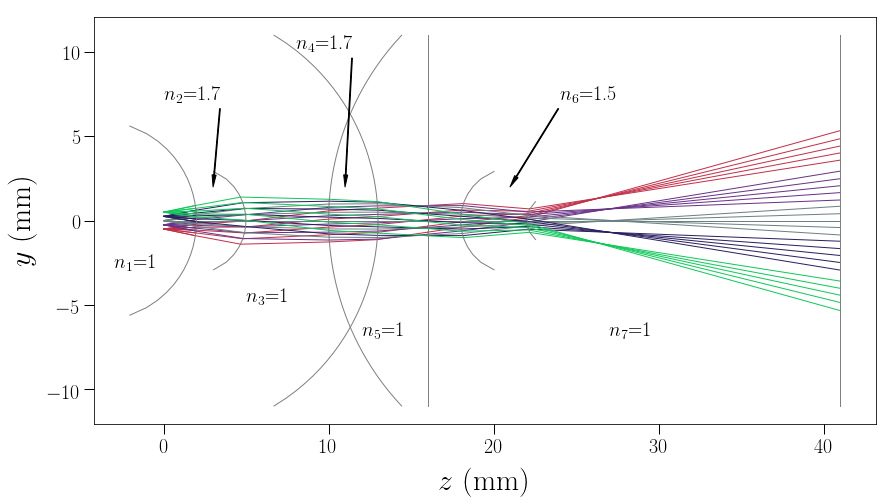

In [5]:
fig = plt.figure(figsize=(14,7.5))
ax = fig.add_subplot(1, 1, 1)
plt.grid(False)

ax.set_ylabel(r'$y$ (mm)',fontsize=30, labelpad=10)
ax.set_xlabel(r'$z$ (mm)',fontsize=30, labelpad=10)
ax.tick_params(labelsize=20,width=1,length=10)

draw_rays(ax, raypaths_draw, linewidth=1)
s.draw2d(ax, color="grey", linewidth=1)

ax.annotate(r'$n_1$=1', xy=(-3, -3), fontsize=20)
ax.annotate(r'$n_2$=1.7', xy=(3, 2), xytext=(0, 7), fontsize=20,
            arrowprops=dict(facecolor='black', width=0.8, headwidth=4))
ax.annotate(r'$n_3$=1', xy=(5, -5), fontsize=20)
ax.annotate(r'$n_4$=1.7', xy=(11, 2), xytext=(8, 10), fontsize=20,
            arrowprops=dict(facecolor='black', width=0.8, headwidth=4))
ax.annotate(r'$n_5$=1', xy=(12, -7), fontsize=20)
ax.annotate(r'$n_6$=1.5', xy=(21, 2), xytext=(24, 7), fontsize=20,
            arrowprops=dict(facecolor='black', width=0.8, headwidth=4))
ax.annotate(r'$n_7$=1', xy=(27, -7), fontsize=20)
fig.savefig('images/ray_tracing.pdf', transparent=True)

plt.show()

Here we will plot some object field points (representing a and their resulting image field point locations to show how the image will be deformed).

The object is represented as an 8x8 array of point sources, each of which consists of a bundle of 70 light rays whose directions are distributed radially.

Each light ray is traced through the optical system to a unique location on the image plane. This image plane can be split into an array of pixels, emulating a CCD detector.

In [6]:
num_pixels = np.array([8,8])
eps_obj = (end_loc-start_loc)/(2*num_pixels)
pix_obj_locs = np.linspace(start_loc, end_loc, num=num_pixels[0])
num_rays = 70

a_spot_pix = Aimy(s, seq, name="Aimy_spot_val", stopsize=1.0, num_pupil_points=num_rays,
                  pilotbundle_solution=-2, pilotbundle_delta_angle=3.*degree,
                  pilotbundle_delta_size=0.05)

raypaths_pix = []

for ystart in pix_obj_locs:
    for xstart in pix_obj_locs:
        initialraybundle_spot = a_spot_pix.aim(np.array([xstart, ystart]),
                                               fieldtype="objectheight")
        initialraybundle_spot = correct_k_E_initialbundle(initialraybundle_spot)

        raypath_spot = s.seqtrace(initialraybundle_spot, seq)
        
        raypaths_pix.append(raypath_spot)

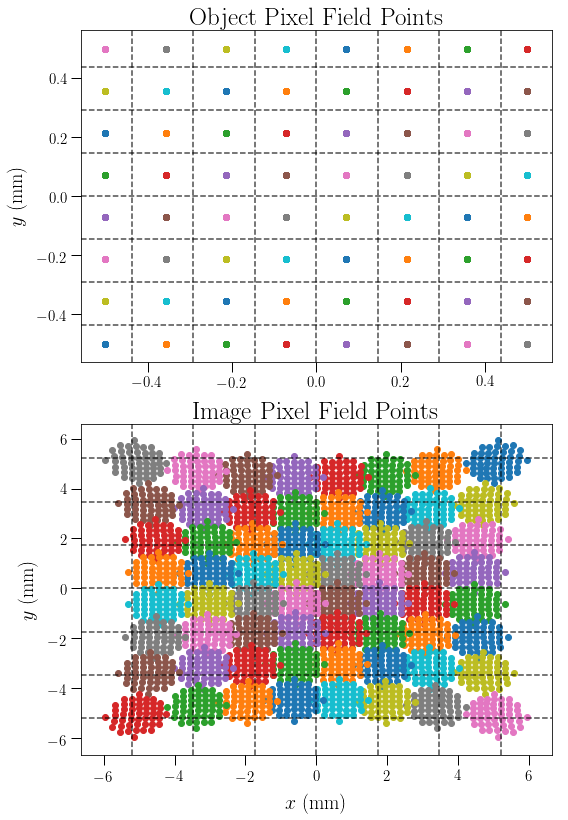

In [7]:
# Plot data
fig = plt.figure(figsize=(8, 11.5)) 
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])
ax0.set_title(r'Object Pixel Field Points', fontsize=25)
ax1.set_title(r'Image Pixel Field Points', fontsize=25)
ax0.set_ylabel(r'$y$ (mm)', fontsize=20, labelpad=10)
ax1.set_xlabel(r'$x$ (mm)', fontsize=20, labelpad=10)
ax1.set_ylabel(r'$y$ (mm)', fontsize=20, labelpad=10)
ax0.tick_params(labelsize=15,width=1,length=10)
ax1.tick_params(labelsize=15,width=1,length=10)

# Min and max image ray locations
min_img = 0
max_img = 0

for i, [rp,] in enumerate(raypaths_pix):
    (sx_obj, sy_obj) = rp.raybundles[0].x[0, 0:2, :]
    (sx_img, sy_img) = rp.raybundles[-1].x[0, 0:2, :]
    pt = ax0.scatter(sx_obj, sy_obj)
    ax1.scatter(sx_img, sy_img)
    
    if np.min([sx_img, sy_img])<min_img:
        min_img = np.min([sx_img, sy_img])
    if np.max([sx_img, sy_img])>max_img:
        max_img = np.max([sx_img, sy_img])
    
# Plot grid

# Size of half of each object pixel
eps_obj = (end_loc-start_loc)/(2*num_pixels)
# Locations of the middle of each pixel
pix_obj_locs = np.linspace(start_loc+eps_obj, end_loc-eps_obj, num=num_pixels[0]-1)

# Size of half of each image pixel
eps_img = (max_img-min_img)/(2*num_pixels)
# Locations of the middle of each pixel
pix_img_locs = np.linspace(min_img+eps_img, max_img-eps_img, num=num_pixels[0]-1)
    
xlim0 = ax0.get_xlim()
ylim0 = ax0.get_ylim()
xlim1 = ax1.get_xlim()
ylim1 = ax1.get_ylim()

for loc0, loc1 in zip(pix_obj_locs, pix_img_locs):
    ax0.plot(loc0, ylim0, 'k--', alpha=0.7)
    ax0.plot(xlim0, loc0, 'k--', alpha=0.7)
    ax1.plot(loc1, ylim1, 'k--', alpha=0.7)
    ax1.plot(xlim1, loc1, 'k--', alpha=0.7)
    
ax0.set_xlim(xlim0)
ax0.set_ylim(ylim0)
ax1.set_xlim(xlim1)
ax1.set_ylim(ylim1)
        
ax0.grid(False)
ax1.grid(False)
fig.tight_layout()

fig.savefig('images/field_points.pdf', transparent=True)
plt.show()

Next we will create a grid of field points that will represent the object. For us, our object will be a 28x28 pixel image, so we will represent this as a 2D grid of field points where each field point sends out 300 rays and each of these rays are traced through the optical system to the image plane.

In [8]:
num_pixels = np.array([28,28])
eps_obj = (end_loc-start_loc)/(2*num_pixels)
pix_obj_locs = np.linspace(start_loc, end_loc, num=num_pixels[0])
num_rays = 300

a_spot_pix = Aimy(s, seq, name="Aimy_spot_val", stopsize=1.0, num_pupil_points=num_rays,
                  pilotbundle_solution=-2, pilotbundle_delta_angle=3.*degree,
                  pilotbundle_delta_size=0.05)

raypaths_pix = []

for ystart in pix_obj_locs:
    for xstart in pix_obj_locs:
        initialraybundle_spot = a_spot_pix.aim(np.array([xstart, ystart]),
                                               fieldtype="objectheight")
        initialraybundle_spot = correct_k_E_initialbundle(initialraybundle_spot)

        raypath_spot = s.seqtrace(initialraybundle_spot, seq)
        
        raypaths_pix.append(raypath_spot)

Here we will collect the object and image ray locations. We will also collect the field point number for indexing later on. Lastly, we will calculate the minimum and maximum image ray locations so that we can set up a grid for our image pixels.

In [9]:
# Object field point locations
loc_obj = []
# Image field point locations
loc_img = []
# Field point numbers
fp_num = []
# Min and max image ray locations
min_img = 0
max_img = 0
for i, [rp,] in enumerate(raypaths_pix):
    (sx, sy) = rp.raybundles[0].x[0, 0:2, :]
    loc_obj.append(np.vstack((sx,sy)).T)
    (sx, sy) = rp.raybundles[-1].x[0, 0:2, :]
    loc_img.append(np.vstack((sx,sy)).T)
    fp_num.append(np.ones(len(sx))*i)
    
    if np.min([sx, sy])<min_img:
        min_img = np.min([sx, sy])
    if np.max([sx, sy])>max_img:
        max_img = np.max([sx, sy])
    
loc_obj = np.concatenate(loc_obj)
loc_img = np.concatenate(loc_img)
fp_num = np.concatenate(fp_num)

Now we will load our dataset of images for training and plot and example of what one looks like. For now, we will not use our test set and instead we will create a cross-validation set when training. We will only introduce the test set once our model is decided upon and we are ready to present our results.

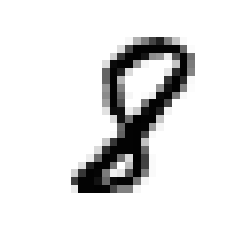

In [10]:
import tensorflow as tf
(mnist_obj_tr, _), (mnist_obj_te, _) = tf.keras.datasets.mnist.load_data()

plt.imshow(mnist_obj_tr[-33], interpolation='none', 
           cmap='Greys')
plt.axis('off')
plt.savefig('images/object.pdf', transparent=True)
plt.show()

Create some arrays of the pixel values for both the training and test sets. These will be used to index into when we need to determine a weighted average of them on the image side.

In [11]:
# Determine pixel value starting in the bottom left and moving 
# across before going to the next row.
pix_values_tr = []
for y in range(len(mnist_obj_tr[0])):
    for x in range(len(mnist_obj_tr[0])):
        pix_values_tr.append(mnist_obj_tr[:,-y,x])
pix_values_tr = np.array(pix_values_tr).T

pix_values_te = []
for y in range(len(mnist_obj_te[0])):
    for x in range(len(mnist_obj_te[0])):
        pix_values_te.append(mnist_obj_te[:,-y,x])
pix_values_te = np.array(pix_values_te).T

Using the image locations of the rays, we will determine which rays land on which image pixel and calculate the average greyscale value of all of the rays that land on the pixel of interest. We can vectorize this quite easily to do one pixel at a time for the entire dataset.

In [12]:
# Size of half of each image pixel
eps_img = (max_img-min_img)/(2*num_pixels)
# Locations of the middle of each pixel
pix_img_locs = np.linspace(min_img+eps_img, max_img-eps_img, num=num_pixels[0])

# Training images
mnist_img_tr = np.zeros_like(mnist_obj_tr)
for y, y_loc in enumerate(pix_img_locs[:,1]):
    for x, x_loc in enumerate(pix_img_locs[:,0]):
            
        # Find image rays that fit in the current pixel
        indices = np.where((loc_img[:,0]>=x_loc-eps_img[0])&
                           (loc_img[:,0]<x_loc+eps_img[0])&
                           (loc_img[:,1]>=y_loc-eps_img[1])&
                           (loc_img[:,1]<y_loc+eps_img[1]))[0]
        # Collect the original pixel values of these rays
        rp_indices = fp_num[indices].astype(int)
        # Calculate average of all of them
        if len(rp_indices)>0:
            avg_pix = np.mean(pix_values_tr[:,rp_indices], axis=1)
        else:
            avg_pix = np.zeros((len(pix_values_tr)))
        mnist_img_tr[:,-y,x] = avg_pix

# Test images
mnist_img_te = np.zeros_like(mnist_obj_te)
for y, y_loc in enumerate(pix_img_locs[:,1]):
    for x, x_loc in enumerate(pix_img_locs[:,0]):
            
        # Find image rays that fit in the current pixel
        indices = np.where((loc_img[:,0]>=x_loc-eps_img[0])&
                           (loc_img[:,0]<x_loc+eps_img[0])&
                           (loc_img[:,1]>=y_loc-eps_img[1])&
                           (loc_img[:,1]<y_loc+eps_img[1]))[0]
        # Collect the original pixel values of these rays
        rp_indices = fp_num[indices].astype(int)
        # Calculate average of all of them
        if len(rp_indices)>0:
            avg_pix = np.mean(pix_values_te[:,rp_indices], axis=1)
        else:
            avg_pix = np.zeros((len(pix_values_te)))
        mnist_img_te[:,-y,x] = avg_pix

An example of what the input looks like on the image plane.

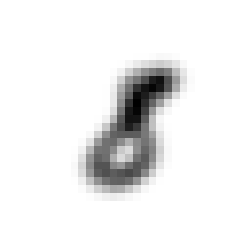

In [13]:
plt.imshow(mnist_img_tr[-33], interpolation='none', 
           cmap='Greys')
plt.axis('off')
plt.savefig('images/image.pdf', transparent=True)
plt.show()

Now we will normalize the pixel values between 0 and 1.

$$x_{norm}=\frac{x}{max(x)}$$

Normalizing the data is pretty typical in machine learning and this operation can easily be reversed if we want to return the pixel values to their original scale. However, this *denormalization* probably won't be necessary because we are just interested in their relative values in order to visualize them.

Here we will also reshape the inputs into the correct shape for 2D Convolutional layers. For $N$ samples with 28x28 pixels and one channel (ie. grayscale) this looks like ($N$,28,28,1)

In [14]:
image_size = mnist_obj_tr.shape[1]
mnist_obj_tr = np.reshape(mnist_obj_tr, [-1, image_size, image_size, 1])
mnist_img_tr = np.reshape(mnist_img_tr, [-1, image_size, image_size, 1])
mnist_obj_te = np.reshape(mnist_obj_te, [-1, image_size, image_size, 1])
mnist_img_te = np.reshape(mnist_img_te, [-1, image_size, image_size, 1])
mnist_obj_tr = mnist_obj_tr.astype('float32') / 255
mnist_img_tr = mnist_img_tr.astype('float32') / 255
mnist_obj_te = mnist_obj_te.astype('float32') / 255
mnist_img_te = mnist_img_te.astype('float32') / 255

Now we will define the model architecture. We will use an auto-encoder, whose framework was mostly taken from https://keras.io/examples/mnist_denoising_autoencoder/.

In [15]:
from keras.layers import (Activation, Dense, Input, Conv2D, 
                          Flatten, Reshape, Conv2DTranspose)
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from PIL import Image
import math

# Network parameters

# Shape of input images
input_shape = (image_size, image_size, 1)
# Learning rate
lr = 0.001
# Number of training samples per batch iteration
batch_size = 128
# Number of training epochs
epochs = 150
# Length of the convolutional filters
kernel_size = 3
# Stride length of convolutional layers
stride = 2
# Size of the latent-space
latent_dim = 128
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Autoencoder Architecture

# First build the Encoder Model

# Input nodes
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=stride,
               activation='relu',
               padding='same')(x)

# Shape needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer=Adam(lr=lr))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 128)               401536    
Total params: 420,352
Trainable params: 420,352
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
deco

Finally, we will traing the model using the last 10% of the training data as the cross-validation set (ie. *validation_split=0.1*)

In [16]:
# Train the autoencoder
history = autoencoder.fit(mnist_img_tr,
                          mnist_obj_tr,
                          validation_split=0.1,
                          epochs=epochs,
                          verbose=0,
                          batch_size=batch_size)

Plot the training progress.

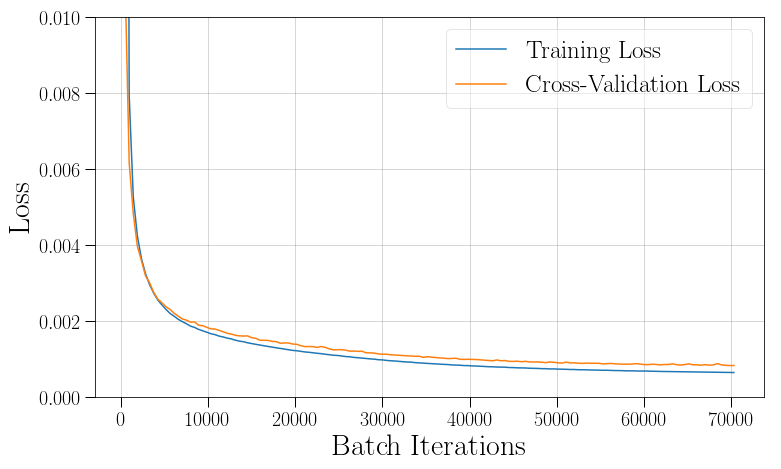

In [17]:
batch_iters = np.arange(len(mnist_img_tr)/batch_size, 
                        epochs*len(mnist_img_tr)/batch_size + len(mnist_img_tr)/batch_size,
                        len(mnist_img_tr)/batch_size)

plt.figure(figsize=(12,7))
plt.plot(batch_iters, history.history['loss'], label='Training Loss')
plt.plot(batch_iters, history.history['val_loss'], label='Cross-Validation Loss')
plt.ylabel('Loss',fontsize=30)
plt.xlabel('Batch Iterations',fontsize=30)
plt.tick_params(labelsize=20,width=1,length=10)
plt.legend(fontsize=25, framealpha=0.5)
plt.ylim(0,0.01)
plt.savefig('images/training_progress.pdf', transparent=True)
plt.show()

It looks like the model may still be converging and chances are we can make modifications to the architecture and training parameters to improve the results. However, without getting too caught up in minor details, this will be probably be fine for our purposes.

Next we will use the trained model to predict - from the deformed images - the resolved object. We will plot the original *object*, the deformed *image*, the *predicted* object, and the *residual* between the original and predicted object.

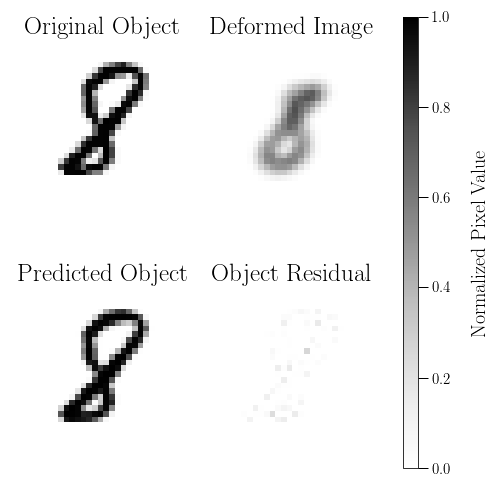

In [18]:
# Predict on the entire training set
mnist_pred_tr = autoencoder.predict(mnist_img_tr)

# Grab a sample to plot the results
sample_indx = -33
# Calculate the residual between the original object and the predicted object
resid = (mnist_pred_tr[sample_indx,:,:,0]-mnist_obj_tr[sample_indx,:,:,0])

fig = plt.figure(figsize=(7, 7)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,0.1])

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[:, 2])
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax0.set_title(r'Original Object', fontsize=25)
ax1.set_title(r'Predicted Object', fontsize=25)
ax2.set_title(r'Deformed Image', fontsize=25)
ax3.set_title(r'Object Residual', fontsize=25)

pts = ax0.imshow(mnist_obj_tr[sample_indx,:,:,0], interpolation='none', 
           cmap='Greys', vmin=0, vmax=1)
ax1.imshow(mnist_pred_tr[sample_indx,:,:,0], interpolation='none', 
           cmap='Greys', vmin=0, vmax=1)
ax2.imshow(mnist_img_tr[sample_indx,:,:,0], interpolation='none', 
           cmap='Greys', vmin=0, vmax=1)
ax3.imshow(resid, interpolation='none', 
           cmap='Greys', vmin=0, vmax=1)

# Colour bar
fig.colorbar(pts, cax=ax4)
ax4.set_ylabel(r'Normalized Pixel Value', fontsize=20, labelpad=20)
ax4.tick_params(labelsize=15,width=1,length=10)

fig.tight_layout()
plt.savefig('images/prediction_example.pdf', transparent=True)
plt.show()

Show some more samples from the test set.

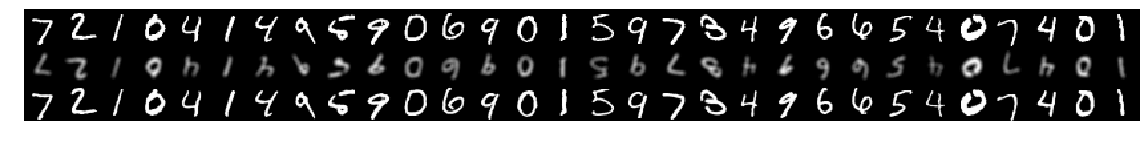

In [22]:
# Predict on the entire test set
mnist_pred_te = autoencoder.predict(mnist_img_te)


# Display the first 30 images
rows, cols = 1, 30
num = rows * cols
imgs = np.concatenate([mnist_obj_te[0:num], 
                       mnist_img_te[0:num], 
                       mnist_pred_te[0:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(20,5))
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('images/multiple_prediction_examples.pdf', transparent=True, 
            bbox_inches='tight', pad_inches=0)

plt.show()